In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import mean_squared_error as MSE

from xgboost import XGBClassifier


In [3]:
train = pd.read_csv('../input/titanic/train.csv')

## 1. EDA

In [4]:
display(train.tail())
display(train.head())
display(train.describe())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

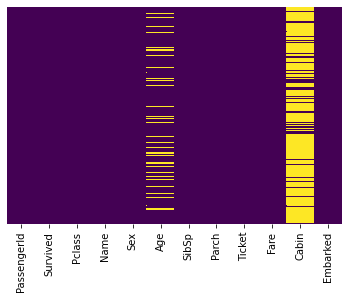

In [5]:
display(train.isnull().sum().sort_values(ascending=False))
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [6]:
# As we can see from the plot above, most of the Cabin field is empty, and a significant amount of age is empty, we will drop cabin, and try to infer age values

train.drop('Cabin',axis=1,inplace=True)

## 2. Data Visualization

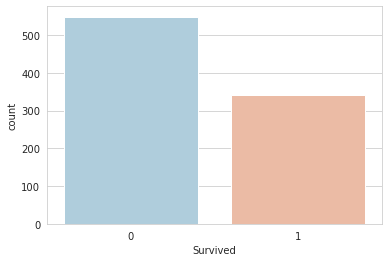

In [7]:
# Let's first checkout the comparison of the number of survived V. those who couldn't
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='RdBu_r')

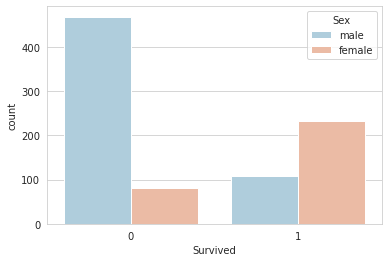

In [9]:
# Let's checkout the survival ratings on the basis of Sex
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

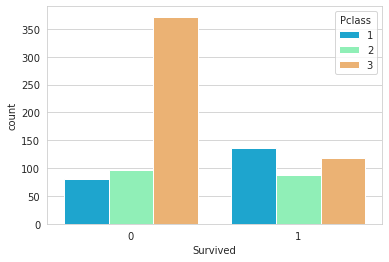

In [10]:
# Let's checkout if class of your ticket had to do anything with your survival
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

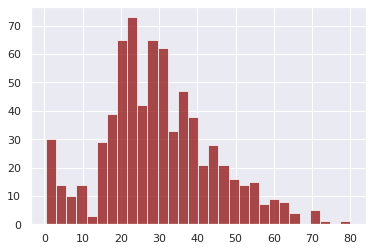

In [12]:
sns.set()
train['Age'].hist(bins=30,color='darkred',alpha=0.7)

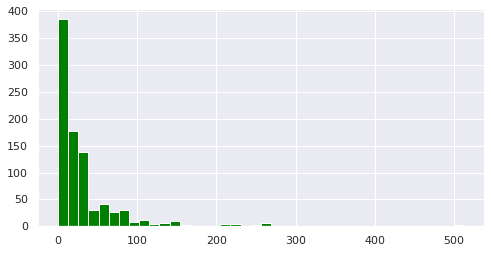

In [13]:
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

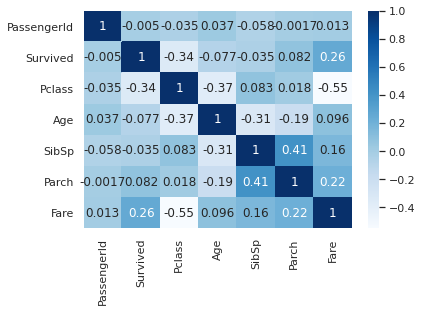

In [16]:
# Next up, let's see the correlation within variables
corr_matrix = train.corr()
sns.heatmap(corr_matrix, annot = True, cmap = 'Blues')
plt.show()


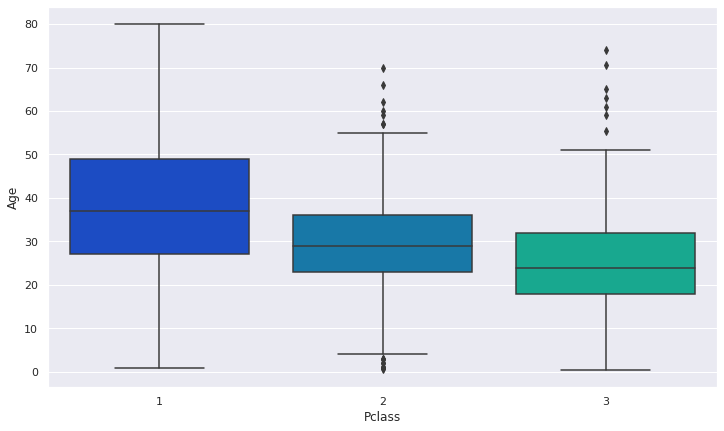

In [14]:
# Let's try to figure out the relationship between age and Pclass. So that we can fill the entries of age with logical values
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

## 3. Data Preparation

In [20]:
# As we can see from the plot above, age is roughly related to Pclass, and we will try to fill the age values using the Pclass value
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24

    else:
        return Age
    
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)
# And we also fill the two missing Embarked values
train['Embarked'] = train['Embarked'].fillna('S')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


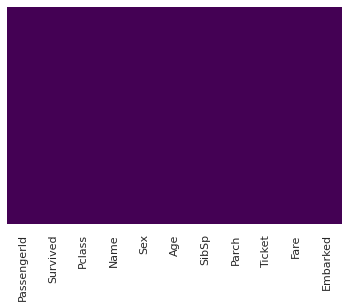

In [24]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')
train.info()

In [25]:
sex = pd.get_dummies(train['Sex'],drop_first=True)
embark = pd.get_dummies(train['Embarked'],drop_first=True)
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)
train = pd.concat([train,sex,embark],axis=1)
display(train.head())

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.0,1,0,7.2500,1,0,1
1,2,1,1,38.0,1,0,71.2833,0,0,0
2,3,1,3,26.0,0,0,7.9250,0,0,1
3,4,1,1,35.0,1,0,53.1000,0,0,1
4,5,0,3,35.0,0,0,8.0500,1,0,1


In [27]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['Survived'],axis=1), 
                                                    train['Survived'], test_size=0.10, 
                                                    random_state=101)

## 4. Model Training

In [30]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions_1 = logmodel.predict(X_test)
#X_test.head()
display(predictions_1)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1])

In [32]:
dt_model=DecisionTreeClassifier()
dt_model.fit(X_train,y_train)
predictions_2 = dt_model.predict(X_test)
display(predictions_2)

array([0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1])

In [34]:
rf= RandomForestClassifier(n_estimators=500)
rf.fit(X_train,y_train)
predictions_3 = rf.predict(X_test)
display(predictions_3)

array([0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1])

In [36]:
xgboost = XGBClassifier(n_estimators=1000)
xgboost.fit(X_train,y_train)
predictions_4 = xgboost.predict(X_test)
display(predictions_4)

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0])

## 5. Results Analysis

#### Results of Logistic Regression

In [37]:
print(confusion_matrix(y_test,predictions_1))

[[45  6]
 [15 24]]


In [38]:
print(classification_report(y_test,predictions_1))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81        51
           1       0.80      0.62      0.70        39

    accuracy                           0.77        90
   macro avg       0.78      0.75      0.75        90
weighted avg       0.77      0.77      0.76        90



#### Results of Decision Tree Classifier

In [39]:
print(confusion_matrix(y_test,predictions_2))

[[42  9]
 [15 24]]


In [40]:
print(classification_report(y_test,predictions_2))

              precision    recall  f1-score   support

           0       0.74      0.82      0.78        51
           1       0.73      0.62      0.67        39

    accuracy                           0.73        90
   macro avg       0.73      0.72      0.72        90
weighted avg       0.73      0.73      0.73        90



#### Results of Random Forest Classifier
(with 500 estimators)

In [41]:
print(confusion_matrix(y_test,predictions_3))

[[48  3]
 [15 24]]


In [42]:
print(classification_report(y_test,predictions_3))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84        51
           1       0.89      0.62      0.73        39

    accuracy                           0.80        90
   macro avg       0.83      0.78      0.78        90
weighted avg       0.82      0.80      0.79        90



#### Results of XGBoost Classifier

In [43]:
print(confusion_matrix(y_test,predictions_4))

[[45  6]
 [16 23]]


In [44]:
print(classification_report(y_test,predictions_4))

              precision    recall  f1-score   support

           0       0.74      0.88      0.80        51
           1       0.79      0.59      0.68        39

    accuracy                           0.76        90
   macro avg       0.77      0.74      0.74        90
weighted avg       0.76      0.76      0.75        90

